# Lab 4

**Lecture**: Deep Learning (Prof. Dr. David Rügamer, Emanuel Sommer)

Welcome to the fourth lab. In this lab, we will derive the backpropagation equations, 
code the training procedure, and test it on our beloved dataset with five points.

## Imports

In [1]:
from typing import Optional, List, Tuple

import matplotlib.pyplot as plt
import torch
from matplotlib_inline.backend_inline import set_matplotlib_formats
from torch import Tensor

set_matplotlib_formats('png', 'pdf')


## Exercise 1
Consider a neural network with $L$ layers and a loss function
$\mathcal{L}(\textbf{y},\textbf{z}^{(L)}_{\cdot,out})$. Call the output of the $i$-th
unit of the $\ell$-th layer $\textbf{z}^{(\ell)}_{i,out}=\sigma^{(\ell)}(\textbf{z}^{(\ell)}_{i,in})$
with $\textbf{z}^{(\ell)}_{i,in}=\sum_j\textbf{W}^{(\ell)}_{ji}\textbf{z}^{(\ell-1)}_{j,out}+\textbf{b}^{(\ell)}_{i}$
its pre-activation output. Finally, consider $\delta^{(\ell)}_i=\partial\mathcal{L}(\textbf{y},\textbf{z}^{(L)}_{\cdot,out})/\partial\mathbf{z}^{(\ell)}_{i,in}$
the gradient of the loss with respect to the pre-activation outputs of layer $\ell$.

Derive the back-propagation algorithm for a network with arbitrary architecture.
You might find the results of the previous lab a useful reference, as well as chapter
5 of the book _Mathematics for Machine Learning_ (https://mml-book.github.io).


1. Show that

\begin{align}
\delta^{(L)}_i &= \frac{\partial\mathcal{L}(\textbf{y},\textbf{z}^{(L)}_{\cdot,out})}{\partial\textbf{z}^{(L)}_{i,out}}
\cdot{\sigma^\prime}^{(L)}(\textbf{z}^{(L)}_{i,in})
\\
\frac{\partial \mathcal{L}(\textbf{y},\textbf{z}^{(L)}_{\cdot,out})}{\partial \textbf{W}^{(\ell)}_{ji}}&=\delta^{(\ell)}_i\cdot\textbf{z}^{(\ell-1)}_{j,out} \\
\frac{\partial \mathcal{L}(\textbf{y},\textbf{z}^{(L)}_{\cdot,out})}{\partial \textbf{b}^{(\ell)}_{i}}&=\delta^{(\ell)}_i \\
\delta^{(\ell-1)}_i&=\left(\sum_k\delta^{(\ell)}_k\cdot\textbf{W}^{(\ell)}_{ik}\right)\cdot{\sigma^\prime}^{(\ell-1)}(\textbf{z}^{(\ell-1)}_{i,in})
\end{align}

2. Use vectorized operations (i.e., operations with vectors and matrices) to compute
the gradients with respect to a single sample.

3. (Optional) Extend the vectorized operations to handle data in batches, and show that:

\begin{align}
\Delta^{(L)}&=\nabla_{\textbf{Z}^{(L)}_{out}}\mathcal{L}(\textbf{Y},\textbf{Z}^{(L)}_{out})\odot{\sigma^\prime}^{(L)}(\textbf{Z}^{(L)}_{in}) \\
\nabla_{\textbf{W}^{(\ell)}}\mathcal{L}(\textbf{Y},\textbf{Z}^{(\ell)}_{out})&={\textbf{Z}^{(\ell-1)}_{out}}^T \cdot\Delta^{(\ell)} \\
\nabla_{\textbf{b}^{(\ell)}}\mathcal{L}(\textbf{Y},\textbf{Z}^{(L)}_{out})&=\sum_i {\Delta^{(\ell)}_i}^T \\
\Delta^{(\ell-1)}&=\Delta^{(\ell)}{\textbf{W}^{(\ell)}}^T\odot{\sigma^\prime}^{(\ell-1)}(\textbf{Z}^{(\ell-1)}_{in})
\end{align}

where $\Delta^{(\ell)}$, $\textbf{Y}$ and $\textbf{Z}^{(\ell)}_{out}$ are matrices whose $i$-th row contain the respective vectors $\delta$, $\textbf{y}$ and $\textbf{z}^{(\ell)}_{\cdot,out}$ for the $i$-th sample in the batch, and $\odot$ is the element-wise product.



### Solution

#### Question 1

By applying the chain rule, we have, for the last layer:

\begin{align}
\delta^{(L)}_i
&=\frac{\partial\mathcal{L}(\textbf{y},\textbf{z}^{(L)}_{\cdot,out})}{\partial\textbf{z}^{(L)}_{i,in}}
=\frac{\partial\mathcal{L}(\textbf{y},\textbf{z}^{(L)}_{\cdot,out})}{\partial\textbf{z}^{(L)}_{i,out}}
  \cdot\frac{\partial\textbf{z}^{(L)}_{i,out}}{\partial\textbf{z}^{(L)}_{i,in}}
=
\underbrace{
  \frac{\partial\mathcal{L}(\textbf{y},\textbf{z}^{(L)}_{\cdot,out})}{\partial\textbf{z}^{(L)}_{i,out}}
}_{\text{Loss-dependent}}\cdot{\sigma^\prime}^{(L)}(\textbf{z}^{(L)}_{i,in})
\end{align}

Where the first term depends on the loss function. Using the chain rule again,
the derivatives of the weights of a generic layer $\ell$ are:

\begin{align}
\frac{
  \partial \mathcal{L}(\textbf{y},\textbf{z}^{(L)}_{\cdot,out})
}{
  \partial \textbf{W}^{(\ell)}_{ji}
}
&=\frac{
  \partial \mathcal{L}(\textbf{y},\textbf{z}^{(L)}_{\cdot,out})
}{
  \partial \textbf{z}^{(\ell)}_{i,in}
}\cdot\frac{
  \partial \textbf{z}^{(\ell)}_{i,in}
}{
  \partial \textbf{W}^{(\ell)}_{ji}
} \\
&=\delta^{(\ell)}_i\cdot\frac{
  \partial
}{
  \partial \textbf{W}^{(\ell)}_{ji}
}\underbrace{\left(
  \sum_k\textbf{W}^{(\ell)}_{ki}\textbf{z}^{(\ell-1)}_{k,out}+\textbf{b}^{(\ell)}_{i}
\right)}_{\textbf{z}^{(\ell)}_{i,in}} \\
&=\delta^{(\ell)}_i\cdot\textbf{z}^{(\ell-1)}_{j,out}
\end{align}

And, as for the bias:

\begin{align}
\frac{
  \partial \mathcal{L}(\textbf{y},\textbf{z}^{(L)}_{\cdot,out})
}{
    \partial \textbf{b}^{(\ell)}_{i}
}
&=\frac{
  \partial \mathcal{L}(\textbf{y},\textbf{z}^{(L)}_{\cdot,out})
}{
  \partial \textbf{z}^{(\ell)}_{i,in}
}\cdot\frac{
  \partial \textbf{z}^{(\ell)}_{i,in}
}{
  \partial \textbf{b}^{(\ell)}_{i}
} \\
&=\delta^{(\ell)}_i\cdot\frac{
  \partial
}{
  \partial \textbf{b}^{(\ell)}_{i}
}\underbrace{\left(
  \sum_k\textbf{W}^{(\ell)}_{ki}\textbf{z}^{(\ell-1)}_{k,out}+\textbf{b}^{(\ell)}_{i}
\right)}_{\textbf{z}^{(\ell)}_{i,in}} \\
&=\delta^{(\ell)}_i
\end{align}

Finally, the deltas of the previous layer are:

\begin{align}
\delta^{(\ell-1)}_i
&=\frac{
  \partial\mathcal{L}(\textbf{y},\textbf{z}^{(L)}_{\cdot,out})
}{
  \partial\mathbf{z}^{(\ell-1)}_{i,in}
} \\
&=\frac{
  \partial\mathcal{L}(\textbf{y},\textbf{z}^{(L)}_{\cdot,out})
}{
  \partial\mathbf{z}^{(\ell-1)}_{i,out}
}
\cdot\frac{
  \partial\mathbf{z}^{(\ell-1)}_{i,out}
}{
  \partial\mathbf{z}^{(\ell-1)}_{i,in}
} \\
&=\left(
  \sum_k\frac{
    \partial\mathcal{L}(\textbf{y},\textbf{z}^{(L)}_{\cdot,out})
  }{
    \partial\mathbf{z}^{(\ell)}_{k,in}
  }\cdot\frac{
    \partial\mathbf{z}^{(\ell)}_{k,in}
  }{
    \partial\mathbf{z}^{(\ell-1)}_{i,out}
  }
\right)
\cdot{\sigma^\prime}^{(\ell-1)}(\textbf{z}^{(\ell-1)}_{i,in}) \\
&=\left(
  \sum_k
  \delta^{(\ell)}_k
  \cdot\frac{
    \partial
  }{
    \partial\mathbf{z}^{(\ell-1)}_{i,out}
  }\left(
    \sum_l\textbf{W}^{(\ell)}_{lk}\textbf{z}^{(\ell-1)}_{l,out}+\textbf{b}^{(\ell)}_{k}
  \right)
\right)\cdot{\sigma^\prime}^{(\ell-1)}(\textbf{z}^{(\ell-1)}_{i,in}) \\
&=\left(
  \sum_k\delta^{(\ell)}_k\cdot\textbf{W}^{(\ell)}_{ik}
\right)\cdot{\sigma^\prime}^{(\ell-1)}(\textbf{z}^{(\ell-1)}_{i,in})
\end{align}

#### Question 2

The trick to find vectorized formulas is to see how to compute the previous equations
all at the same time via matrix multiplication. Always check the dimensionality of the
matrices and vectors involved, to make sure the shape of the result matches what it
should be.

For the last deltas, each neuron is treated independently from the others,
therefore an element-wise multiplication between the two vectors does the job:

\begin{equation}
\begin{aligned}
\delta^{(L)}
&=\nabla_{\textbf{z}^{(L)}_{\cdot,out}}\mathcal{L}(\textbf{y},\textbf{z}^{(L)}_{\cdot,out})
\odot{\sigma^\prime}^{(L)}(\textbf{z}^{(L)}_{\cdot,in}) \\
(N^{(L)}\times 1) &= (N^{(L)}\times 1) \odot (N^{(L)}\times 1)
\end{aligned}
\end{equation}

Where the second row indicates the dimensionality, rows times columns, of the
elements involved.

To compute the gradients for the weights in Eq. 2, we multiply
every activation of the previous layer by every delta of the current layer,
resulting into a matrix which contains all combinations of
$\textbf{z}^{(\ell)}_{i,out}$ times $\delta^{(\ell)}_j$. This is computed as an "outer product":

\begin{equation}
\begin{aligned}
\nabla_{\textbf{W}^{(\ell)}}\mathcal{L}(\textbf{y},\textbf{z}^{(L)}_{\cdot,out})&=\textbf{z}^{(\ell-1)}_{\cdot,out}\cdot{\delta^{(\ell)}}^T \\
(N^{(\ell-1)}\times N^{(\ell)})&=(N^{(\ell-1)}\times 1)\cdot (N^{(\ell)}\times 1)^T
\end{aligned}
\end{equation}

The gradient for the biases is easy to compute:

\begin{equation}
\nabla_{\textbf{b}^{(\ell)}}\mathcal{L}(\textbf{y},\textbf{z}^{(L)}_{\cdot,out})=\delta^\ell
\end{equation}

Finally, the deltas for the previous layer:

\begin{equation}
\begin{aligned}
\delta^{(\ell-1)}&=\left(\textbf{W}^{(\ell)}\cdot\delta^{(\ell)}\right)
\odot{\sigma^\prime}^{(\ell-1)}(\textbf{z}^{(\ell-1)}_{\cdot,in}) \\
(N^{(\ell-1)}\times 1)&=\left(
(N^{(\ell-1)}\times N^{(\ell)})\cdot(N^{(\ell)}\times 1)
\right)\odot(N^{(\ell-1)}\times 1)
\end{aligned}
\end{equation}

Which follows because the sum in Eq. 4 is the dot-product of the $i$-th row of $\textbf{W}^{(\ell)}$ with $\delta^{(\ell)}$. Doing this separately for each row results in the matrix-vector multiplication $\textbf{W}^{(\ell)}\cdot\delta^{(\ell)}$.

#### Question 3 (Optional)

We now extend these formulas to handle batched data. Vectors become matrices where each row contains the vector for the corresponding sample in the batch:

 - The sample labels become a matrix $\textbf{Y}$, with $\textbf{Y}_{ij}$ the label for the $j$-th output of the $i$-th sample;
 - The hidden activations become $\textbf{Z}^{(\ell)}_{out}$, with $\textbf{Z}^{(\ell)}_{ij,out}$ the activation of the $j$-th unit in the $\ell$-th layer for the $i$-th sample;
 - The deltas become a matrix $\Delta^{(\ell)}$, where row $i$ contains $\delta^{(\ell)}$ for the $i$-th example in the batch.

Remember, the first thing you should do to understand these formulas is to think at the dimensionality of the vectors and matrices involved and make sure they match.

The delta for the output layer is:

\begin{equation}
\Delta^{(L)}
=\nabla_{\textbf{Z}^{(L)}_{out}}\mathcal{L}(\textbf{Y},\textbf{Z}^{(L)}_{out})
\odot{\sigma^\prime}^{(L)}(\textbf{Z}^{(L)}_{in})
\end{equation}

which looks the same as Eq. 21 above, except that now we are using matrices instead of
 vectors. But the operation is the same: element-wise multiplication.

The gradient with respect to $\textbf{W}^{(\ell)}$ is a bit more involved to compute,
as it includes a three-dimensional tensor: the first dimension is for the samples,
the second dimension is for the neurons of the $(\ell-1)$-th layer, and the third
dimension for the neurons of the $\ell$-th layer. In other words, we are taking the
gradients in Eq. 22, which are matrices, for each sample, and "stacking" them one on
top of each other to get a "cube" of gradients. The element indexed by $i,j,k$ is
the derivative of the loss of the $i$-th sample in the batch with respect to
$\textbf{W}^{(\ell)}_{jk}$.

\begin{equation}
\left(\nabla_{\textbf{W}^{(\ell)}}\mathcal{L}(\textbf{Y},\textbf{Z}^{(L)}_{out})\right)_{ijk}
=\left(
  \frac{\partial \mathcal{L}(\textbf{Y},\textbf{Z}^{(L)}_{out})}{\partial \textbf{W}^{(\ell)}_{jk}}
\right)_i
=\textbf{Z}^{(\ell-1)}_{ij,out}\cdot\Delta^{(\ell)}_{ik}
\end{equation}

To find the gradient of the weights with respect to the whole batch, we need to average this on the first dimension (the samples in the batch) to get the gradient:

\begin{equation}
\frac{\partial\mathcal{L}(\textbf{Y},\textbf{Z}^{(L)}_{out})}{\partial \textbf{W}^{(\ell)}_{jk}}
=\sum_i
\textbf{Z}^{(\ell-1)}_{ij,out}
\cdot\Delta^{(\ell)}_{ik}
\end{equation}

If you look closely, you should realize that this is just a matrix product. Let's use a simpler notation to make it clear:

\begin{equation}
A_{jk}=\sum_i B_{ij}\cdot C_{ik}=\sum_i {\left(B^T\right)}_{ji}\cdot C_{ik}
\end{equation}

Therefore, after much pain:

\begin{equation}
\nabla_{\textbf{W}^{(\ell)}}\mathcal{L}(\textbf{Y},\textbf{Z}^{(\ell)}_{out})
={\textbf{Z}^{(\ell-1)}_{out}}^T
\cdot\Delta^{(\ell)}
\end{equation}

The biases are straightforward, we just have to sum over the deltas of each sample:

\begin{equation}
\nabla_{\textbf{b}^{(\ell)}}\mathcal{L}(\textbf{Y},\textbf{Z}^{(L)}_{out})=\sum_i {\Delta^{(\ell)}_i}^T
\end{equation}

Finally, the deltas of the previous layer. From Eq. 4, each element is:

\begin{equation}
\Delta^{(\ell-1)}_{ij}=\left(
  \sum_k\Delta^{(\ell)}_{ik}\cdot\textbf{W}^{(\ell)}_{jk}
\right)\cdot{\sigma^\prime}^{(\ell-1)}(\textbf{Z}^{(\ell-1)}_{ij,in})
\end{equation}

The sum is again a matrix product, therefore:

\begin{equation}
\Delta^{(\ell-1)}=\Delta^{(\ell)}{\textbf{W}^{(\ell)}}^T\odot{\sigma^\prime}^{(\ell-1)}(\textbf{Z}^{(\ell-1)}_{in})
\end{equation}


## Exercise 2
In this exercise, we will code the backpropagation algorithm
and apply it to our five-points dataset.

First, let's define some structures to quickly create a neural network with layers of
given size. It will use tanh activation in the hidden layers and sigmoid for
the output layer. Although we will use it for classification, we use the mean squared
error loss for a change.

**NOTE**: We use PyTorch only as computation engine. To showcase how backpropagation
works under the hood, we do not utilize auto diff or other structures like modules or
autograd functions in this example (just basic OOP). However, we still use some
conventions like forward/backward notation.

In [2]:
class Linear:
    def __init__(self, in_features: int, out_features: int):
        self.weight = self._init_glorot(in_features, out_features)
        self.bias = torch.zeros(out_features)

        self.weight_grad: Optional[Tensor] = None
        self.bias_grad: Optional[Tensor] = None

    @staticmethod
    def _init_glorot(in_features: int, out_features: int) -> Tensor:
        """Init a weight matrix with glorot initialization."""
        b = torch.sqrt(torch.tensor([6. / (in_features + out_features)]))
        return (2 * b) * torch.rand(in_features, out_features) - b

    def forward(self, x: Tensor) -> Tensor:
        return x @ self.weight + self.bias

class Sigmoid:
    def __init__(self):
        self.func = lambda x: 1 / (1 + torch.exp(-x))

    def forward(self, x: Tensor) -> Tensor:
        return self.func(x)

    def get_gradient(self, x: Tensor) -> Tensor:
        return self.func(x) * (1 - self.func(x))


class TanH:
    @staticmethod
    def forward(x: Tensor) -> Tensor:
        return torch.tanh(x)

    @staticmethod
    def get_gradient(x: Tensor) -> Tensor:
        return  1 - torch.tanh(x)**2

class MSELoss:
    @staticmethod
    def forward(y_true: Tensor, y_pred: Tensor) -> Tensor:
        return torch.mean((y_true - y_pred)**2)

    @staticmethod
    def get_gradient(y_true: Tensor, y_pred: Tensor) -> Tensor:
        return 2 * (y_pred - y_true) / len(y_true)


# Now we bring everything together and create our neural network.
class NeuralLayer:
    def __init__(self, in_features: int, out_features: int, activation: str):
        self.linear = Linear(in_features, out_features)
        
        if activation == 'sigmoid':
            self.act = Sigmoid()
        elif activation == 'tanh':
            self.act = TanH()
        else:
            raise ValueError('{} activation is unknown'.format(activation))

        # We save the last computation as we'll need it for the backward pass.
        self.last_input: Optional[None] = None
        self.last_zin: Optional[None] = None
        self.last_zout: Optional[None] = None

    def forward(self, x: Tensor) -> Tensor:
        self.last_input = x
        self.last_zin = self.linear.forward(x)
        self.last_zout = self.act.forward(self.last_zin)
        return self.last_zout

    def get_weight(self) -> Tensor:
        """Get the weight matrix in the linear layer."""
        return self.linear.weight

    def get_bias(self) -> Tensor:
        """Get the weight matrix in the linear layer."""
        return self.linear.bias

    def set_weight_gradient(self, grad: Tensor) -> None:
        """Set a tensor as gradient for the weight in the linear layer."""
        self.linear.weight_grad = grad

    def set_bias_gradient(self, grad: Tensor) -> None:
        """Set a tensor as gradient for the bias in the linear layer."""
        self.linear.bias_grad = grad


class NeuralNetwork:
    def __init__(self, input_size, output_size, hidden_sizes: List[int]):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes

        self.layers: List[NeuralLayer] = []
        layer_sizes = [self.input_size] + self.hidden_sizes
        for i in range(1, len(layer_sizes)):
            self.layers.append(NeuralLayer(layer_sizes[i-1], layer_sizes[i], 'tanh'))
        self.layers.append(NeuralLayer(hidden_sizes[-1], self.output_size, 'sigmoid'))

        self.loss = MSELoss()

    def forward(self, x: Tensor) -> Tensor:
        for layer in self.layers:
            x = layer.forward(x)
        return x.squeeze(-1)

    def get_loss(self, x: Tensor, y: Tensor) -> Tensor:
        """Compute the loss for a dataset and given labels."""
        return self.loss.forward(y, self.forward(x))

    def backward(self, x: Tensor, y: Tensor) -> None:
        """Compute all gradients over backpropagation."""
        # Perform forward pass.
        # The z's are automatically saved by our NeuralLayer object.
        y_pred = self.forward(x)


        # Compute the gradient of the loss.
        loss_grad = self.loss.get_gradient(y, y_pred)

        # Compute deltas for the output layer.
        z_in = self.layers[-1].last_zin
        act = self.layers[-1].act
        deltas = loss_grad.unsqueeze(-1) * act.get_gradient(z_in)

        # Traverse the whole network backwards and compute gradients on the way.
        # The gradients for the weights/biases are directly stashed within the layer object.
        for i in range(1, len(self.layers)):
            previous_z_out = self.layers[-(i + 1)].last_zout
            previous_z_in = self.layers[-(i + 1)].last_zin
            previous_act_func = self.layers[-(i + 1)].act

            current_layer = self.layers[-i]

            weight_grad = previous_z_out.T @ deltas
            bias_grad = torch.sum(deltas, dim=0)

            current_layer.set_weight_gradient(weight_grad)
            current_layer.set_bias_gradient(bias_grad)

            deltas = deltas @ current_layer.get_weight().T * previous_act_func.get_gradient(previous_z_in)

        # Compute gradients for the input layer.
        self.layers[0].set_weight_gradient(x.T @ deltas)
        self.layers[0].set_bias_gradient(torch.sum(deltas, dim=0))


        # Check if gradients have the right size.
        for i, layer in enumerate(self.layers):
            if layer.linear.weight_grad.shape != layer.linear.weight.shape \
                or layer.linear.bias_grad.shape != layer.linear.bias.shape:
                raise ValueError('Gradients in layer with index {} have a wrong shape.'
                                 .format(i))


    def apply_gradients(self, learning_rate: float) -> None:
        """Update weights with the computed gradients."""
        for layer in self.layers:
            if layer.linear.weight_grad is not None:
                layer.linear.weight -= learning_rate * layer.linear.weight_grad
            if layer.linear.bias_grad is not None:
                layer.linear.bias -= learning_rate * layer.linear.bias_grad


After we have defined our network, we can create it and test if the passes work without
errors on our small dataset.

In [3]:

x = torch.tensor([
    [0, 0],
    [1, 0],
    [0, -1],
    [-1, 0],
    [0, 1]
], dtype=torch.float)
y = torch.tensor([1, 0, 0, 0, 0])

network = NeuralNetwork(
    input_size=2,
    hidden_sizes=[5, 3],
    output_size=1
)

print(network.forward(x))
network.backward(x, y)

tensor([0.5000, 0.5252, 0.3701, 0.4748, 0.6299])


We can inspect the decision boundary as in the
previous exercises for the randomly initialized network:

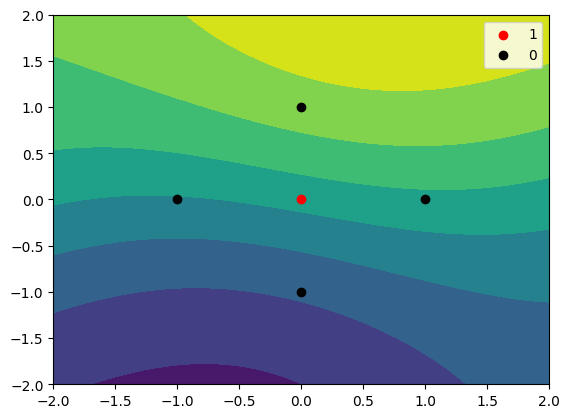

In [4]:

def plot_decision_boundary(x: Tensor, y: Tensor, net: NeuralNetwork) -> None:
    grid_range = torch.linspace(-2, 2, 50)
    grid_x, grid_y = torch.meshgrid(grid_range, grid_range, indexing='ij')
    grid_data = torch.stack([grid_x.flatten(), grid_y.flatten()]).T

    predictions = net.forward(grid_data)

    plt.contourf(grid_x, grid_y, predictions.view(grid_x.shape))
    plt.scatter(x[0, 0], x[0, 1], c='red', label='1')
    plt.scatter(x[1:, 0], x[1:, 1], c='black', label='0')
    plt.legend()
    plt.show()

plot_decision_boundary(x, y, network)

We can now finally train our network!

In [5]:

def train(
        x: Tensor,
        y: Tensor,
        net: NeuralNetwork,
        epochs: int,
        lr: float,
        verbose: int = 1,
) -> Tuple[NeuralNetwork, Tensor]:
    """
    Train a neural network.
    :param x: Training dataset.
    :param y: Training labels.
    :param net: Neural network to train.
    :param epochs: Number of training epochs.
    :param lr: Learning rate for gradient descent.
    :param verbose: Verbosity level. (number of epochs to print loss for)
    :return: Trained network and losses over course of training.
    """


    losses: List = []
    for ep in range(1, epochs + 1):
        # Compute the loss (for tracking).
        loss = net.get_loss(x, y)
        losses.append(loss)

        # Backpropagate gradients.
        net.backward(x, y)

        # Apply gradients.
        net.apply_gradients(learning_rate=lr)

        if verbose > 0 and ep % verbose == 0:
            print('Epoch {}: Loss: {}'.format(ep, loss))

    return net, torch.stack(losses)

network, losses = train(x, y, network, 2500, 0.25, verbose=500)

Epoch 500: Loss: 0.13822922110557556
Epoch 1000: Loss: 0.0042565022595226765
Epoch 1500: Loss: 0.001496790675446391
Epoch 2000: Loss: 0.0008759872289374471
Epoch 2500: Loss: 0.0006118939490988851


By plotting the loss after each parameter update,
we can be sure that the network converged:

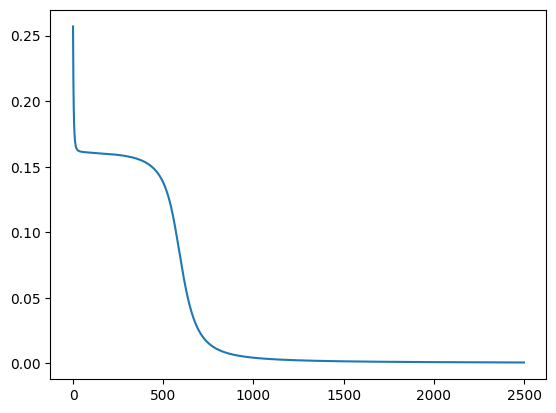

In [6]:

plt.plot(losses)
plt.show()

And the decision boundary of the network is:

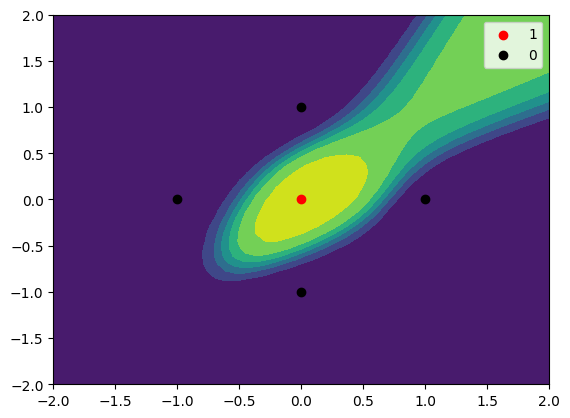

In [7]:

plot_decision_boundary(x, y, network)

Try to train a few randomly initialized networks and vary depth and hidden sizes
to discover different decision boundaries.
Try to modify the learning rate and see how it affects the convergence speed.
Finally, try different ways to initialize the weights and note how the
trainability of the network is affected.